In [7]:
import os
import argparse

import numpy as np
from scipy import stats
from six.moves import cPickle
import hickle
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['font.size'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True

pre_frames = 10 # 50 # 10 # 50
stim_frames = 20 # 80 # 20 # 80
post_frames = 20 # 100 # 20 # 100

n_movies = 100
batch_size = 1

SAVE_DIR = './response/190828_1/'

In [8]:
def classify(resp):
    """
    resp: (2, n_movies, nt, n_units)
    """

    ramping_idx = [] # rampup cell
    ma_idx = [] # motion aftereffect cell
    error_idx = [] # pred erro cell
    motion_idx = [] # motion cell
    flat_idx = [] # non-responsive cell
 
    nt2 = stim_frames + post_frames  
 
    # responsiveness
    resp_mean = np.mean(resp, axis=1) # (2, nt, n_units)
    resp_std = np.std(resp, axis=1) # (2, nt, n_units)
    
    base_mean = np.mean(resp_mean[:, pre_frames // 5: pre_frames, :], axis=1, keepdims=True) # (2, 1, n_units)
    base_std =  np.mean(resp_std[:,  pre_frames // 2: pre_frames, :], axis=1, keepdims=True) # (2, 1, n_units)
    
    """
    # non-responsive cell
    sign = (np.abs(resp_mean[:, pre_frames:, :] - base_mean) > (resp_std[:, pre_frames:, :] + base_std) * 0.5) # (2, 180, n_units)
    c = np.sum(sign, axis=1) < nt2 * 0.1 # (2, n_units)
    flat_idx = np.where(np.sum(c, axis=0) == n_stims)[0]"""
    
    d_resp = np.abs(resp_mean[:, pre_frames:, :] - base_mean)
    d_resp = np.where(d_resp > (resp_std[:, pre_frames:, :] + base_std) * 0.5, d_resp, 0) # (2, 180, n_units)
    
    # non-responsive cell
    c = np.sum(d_resp > 0, axis=1) < nt2 * 0.1 # (2, n_units)
    flat_idx = np.where(np.sum(c, axis=0) == n_stims)[0]

    for i in range(n_units):
        _resp = d_resp[:, :, i] # (2, 180)
        
        if i not in flat_idx:
            # error cell
            m1 = np.mean(_resp[:, :2], axis=-1)
            m2 = np.mean(_resp[:, stim_frames: stim_frames + 2], axis=-1)
            m3 = np.mean(_resp[:, list(range(2, stim_frames)) + list(range(stim_frames + 2, nt2))], axis=-1) # base
            if np.sum(np.logical_or(m1 > 4 * m3, m2 > 4 * m3)):
                error_idx.append(i)            
            # if np.where(_resp == np.max(_resp))[1][0] in [0, 1, stim_frames, stim_frames+1]:
            #     error_idx.append(i)

            m1 = np.sum(_resp[0, :stim_frames])
            m2 = np.sum(_resp[0, stim_frames:])
            m3 = np.sum(_resp[1, :stim_frames])
            m4 = np.sum(_resp[1, stim_frames:])
            if n_stims == 4:
                m5 = np.sum(_resp[2, :stim_frames])
                m6 = np.sum(_resp[2, stim_frames:])
                m7 = np.sum(_resp[3, :stim_frames])
                m8 = np.sum(_resp[3, stim_frames:])

            # ramp cell
            resp_smooth = np.mean(_resp.reshape((n_stims, 10, nt2 // 10)), axis=-1) # (2, 10)
            d = np.diff(resp_smooth, axis=-1) # (2, 9)
            s = np.sign(d)[:, :4]
            if np.sum(np.sum(s == 1, axis=-1) >= 3):
                ramping_idx.append(i)

            # motion cell 
            else:
                if n_stims == 4:
                    if (m1 > m2 * 2 and m1 > m3 * 2 and m1 > m4 * 2) or \
                       (m3 > m4 * 2 and m3 > m1 * 2 and m3 > m2 * 2) or \
                       (m5 > m6 * 2 and m5 > m7 * 2 and m5 > m8 * 2) or \
                       (m7 > m8 * 2 and m7 > m5 * 2 and m7 > m6 * 2):
                        motion_idx.append(i)
                elif n_stims == 2:
                    if (m1 > m2 * 2 and m1 > m3 * 2 and m1 > m4 * 2) or \
                       (m3 > m4 * 2 and m3 > m1 * 2 and m3 > m2 * 2):
                        motion_idx.append(i)

            # after motion cell
            if n_stims == 4:
                if (m1 > m3 * 2 and m4 > m2 * 2) or (m3 > m1 * 2 and m2 > m4 * 2) or \
                   (m5 > m7 * 2 and m8 > m6 * 2) or (m7 > m5 * 2 and m6 > m8 * 2):
                    ma_idx.append(i)
            elif n_stims == 2:
                if (m1 > m3 * 2 and m4 > m2 * 2) or (m3 > m1 * 2 and m2 > m4 * 2):
                    ma_idx.append(i)
    return flat_idx, ramping_idx, ma_idx, error_idx, motion_idx

In [9]:
n_stims = 2
analyze_all = True
# targets = ['E0', 'E1', 'E2', 'R0', 'R1', 'R2', 'A0', 'A1', 'A2', 'Ahat0', 'Ahat1', 'Ahat2']
# targets = ['E2', 'A2', 'Ahat2']
# targets = ['E0', 'A0', 'Ahat0']
# taregets = ['E1', 'A1', 'Ahat1']
targets = ['E2']

cell_dict = {}
for target in targets:
    # load all data
    for n in tqdm(range(n_movies // batch_size)):
        resp_deg0 = hickle.load(SAVE_DIR + 'MAE_P_deg0_' + target + '_' + str(n) + '.hkl') # (batch_size, 230, 12, 14, 192)
        resp_deg180 = hickle.load(SAVE_DIR + 'MAE_P_deg180_' + target + '_' + str(n) + '.hkl')
        if n_stims == 4:
            resp_deg90 = hickle.load(SAVE_DIR + 'MAE_P_deg90_' + target + '_' + str(n) + '.hkl')
            resp_deg270 = hickle.load(SAVE_DIR + 'MAE_P_deg270_' + target + '_' + str(n) + '.hkl')
            
        if n == 0:
            resp = np.zeros((n_stims, n_movies, ) + resp_deg0.shape[1:]) # (2, 100, 230, 12, 14, 192)
            
        resp[0, n * batch_size: (n+1) * batch_size] = resp_deg0
        resp[1, n * batch_size: (n+1) * batch_size] = resp_deg180
        if n_stims == 4:
            resp[2, n * batch_size: (n+1) * batch_size] = resp_deg90
            resp[3, n * batch_size: (n+1) * batch_size] = resp_deg270

    # omit the pre frame
    # resp_ind = np.mean(resp, axis=1)[:, pre_frames:] # (2, 180, 12, 14, 192)
        
    # reshape
    if analyze_all:
        # analyze all units
        n_units = resp.shape[3] * resp.shape[4] * resp.shape[5]
        nt = resp.shape[2]
        resp = resp.reshape((n_stims, n_movies, nt, n_units))
    else:
        # analyze center units
        n_units = resp.shape[-1]
        resp = resp[:, :, :, resp.shape[3]//2, resp.shape[4]//2, :]

    if 'R' in target:
        tmp1 = np.clip(resp, 0, None)
        tmp2 = np.clip(resp, None, 0) * -1
        resp = np.concatenate((tmp1, tmp2), axis=-1)

    print(resp.shape) # (2, 100, 230, n_units)
    
    flat_idx, ramping_idx, ma_idx, error_idx, motion_idx = classify(resp)
    cell_dict[target] = [n_units, flat_idx, ramping_idx, ma_idx, error_idx, motion_idx]
    
# summary
n_cells = np.zeros((len(targets), 6))
for i, target in enumerate(targets):
    n_cells[i][0] = cell_dict[target][0]
    for j in range(1, 6):
        n_cells[i][j] = len(cell_dict[target][j])
        
for i in range(len(n_cells)):
    n1 = n_cells[i, 0] - n_cells[i, 1] - n_cells[i, 4]
    n2 = n_cells[i, 0] - n_cells[i, 1]
    print(n_cells[i, 4] / n2 * 100) # error
    print(n_cells[i, 2] / n2 * 100) # ramp
    print(n_cells[i, 3] / n2 * 100) # ma
    print(n_cells[i, 5] / n2 * 100) # motion
    print()

100%|██████████| 100/100 [00:01<00:00, 70.47it/s]


(2, 100, 50, 32256)
63.29820210787352
15.034097954122752
22.659640421574707
29.169249845009297



In [4]:
if analyze_all:
    hickle.dump(cell_dict, SAVE_DIR + 'cell_dict.hkl')
else:
    hickle.dump(cell_dict, SAVE_DIR + 'cell_dict_center.hkl')

In [175]:
def plot_one(idx, space):
    _resp1 = np.mean(resp[0, :, :, idx], axis=0)
    error1 = np.std(resp[0, :, :, idx], axis=0) / 2
    _resp2 = np.mean(resp[1, :, :, idx], axis=0)
    error2 = np.std(resp[1, :, :, idx], axis=0) / 2
    x = np.arange(0, nt)

    ax = plt.subplot(10, 10, space)
    ax.plot(x, _resp1, 'm-')
    ax.fill_between(x, _resp1 - error1, _resp1 + error1, facecolor=(1,0,1,0.5), edgecolor=(1,0,1,0.5))
    ax.plot(x, _resp2, 'c-')
    ax.fill_between(x, _resp2 - error2, _resp2 + error2, facecolor=(0,1,1,0.5), edgecolor=(0,1,1,0.5))
    ax.axvspan(pre_frames, pre_frames + stim_frames - 0.5, facecolor='g', alpha=0.1)
    plt.setp(ax.get_xticklabels(), visible=False)
    ax.set_xticks(np.arange(0, nt, 10))

    # title = str(idx)
    title = ''
    if idx in ramping_idx:
        title += 'r'
    if idx in ma_idx:
        title += 'a'
    if idx in motion_idx:
        title += 'm'
    if idx in error_idx:
        title += 'e'
    ax.set_title(title, fontsize=16)

def plotter(idxs, start):
    for i in range(20):
        plot_one(idxs[i], start+i)

/home/ukita/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


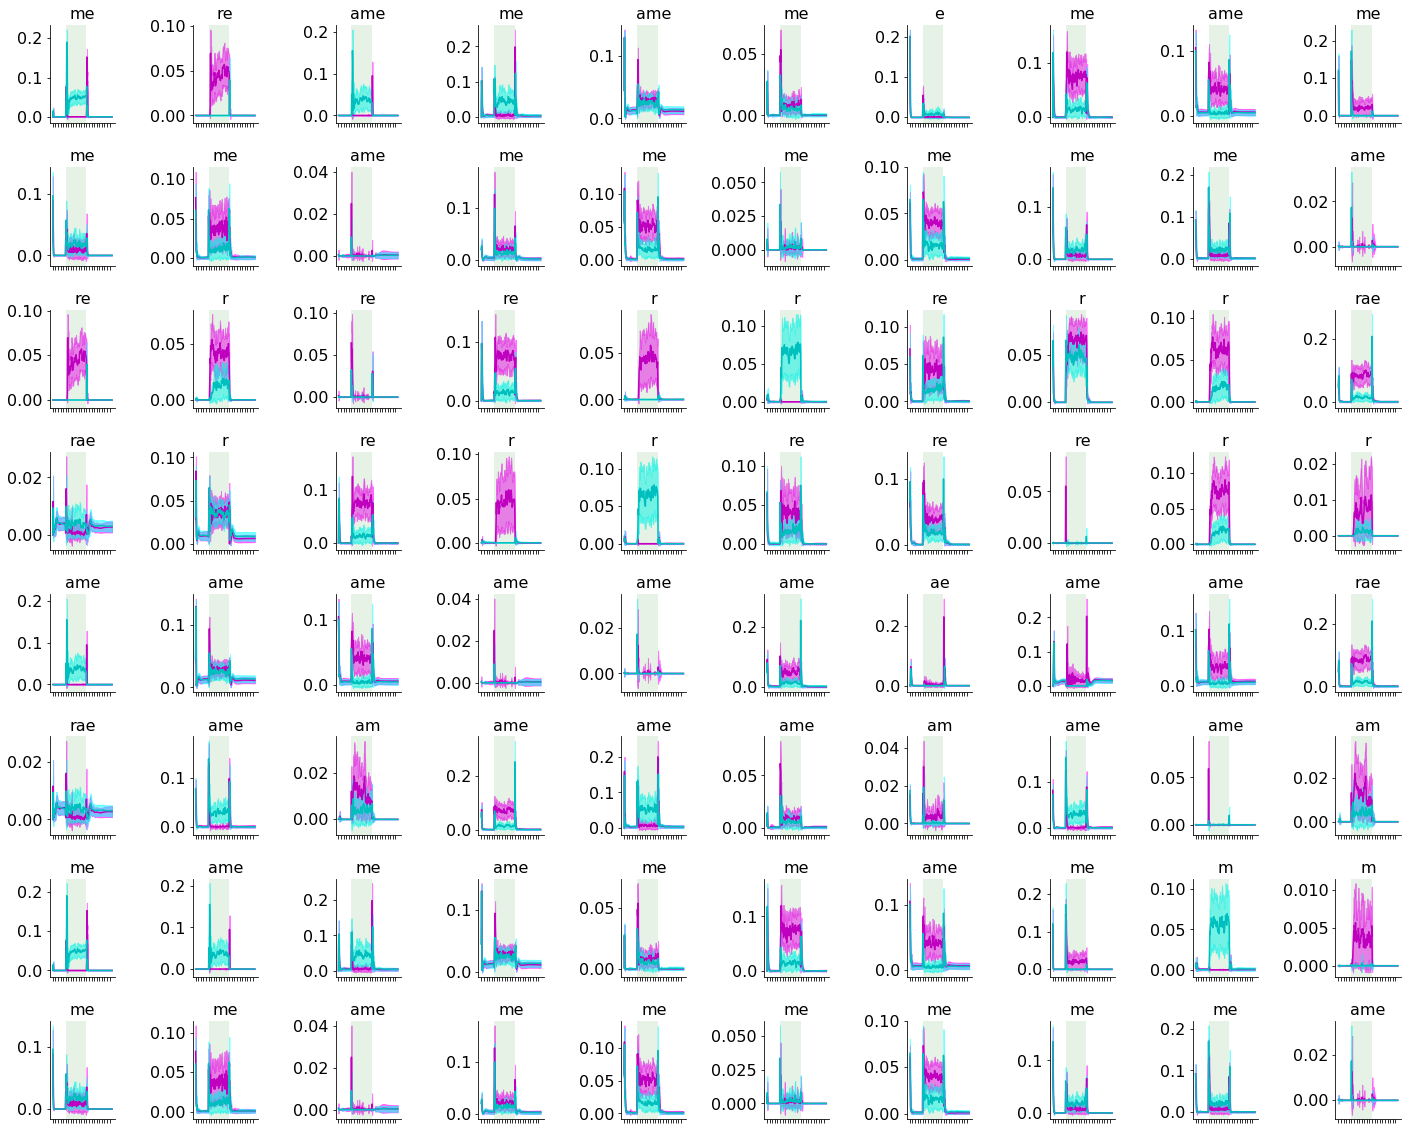

In [176]:
fig = plt.figure(figsize=(20, 20))
plotter(error_idx, 1)
plotter(ramping_idx, 21)
plotter(ma_idx, 41)
plotter(motion_idx, 61)
plt.tight_layout()
plt.show()
plt.close()

/home/ukita/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


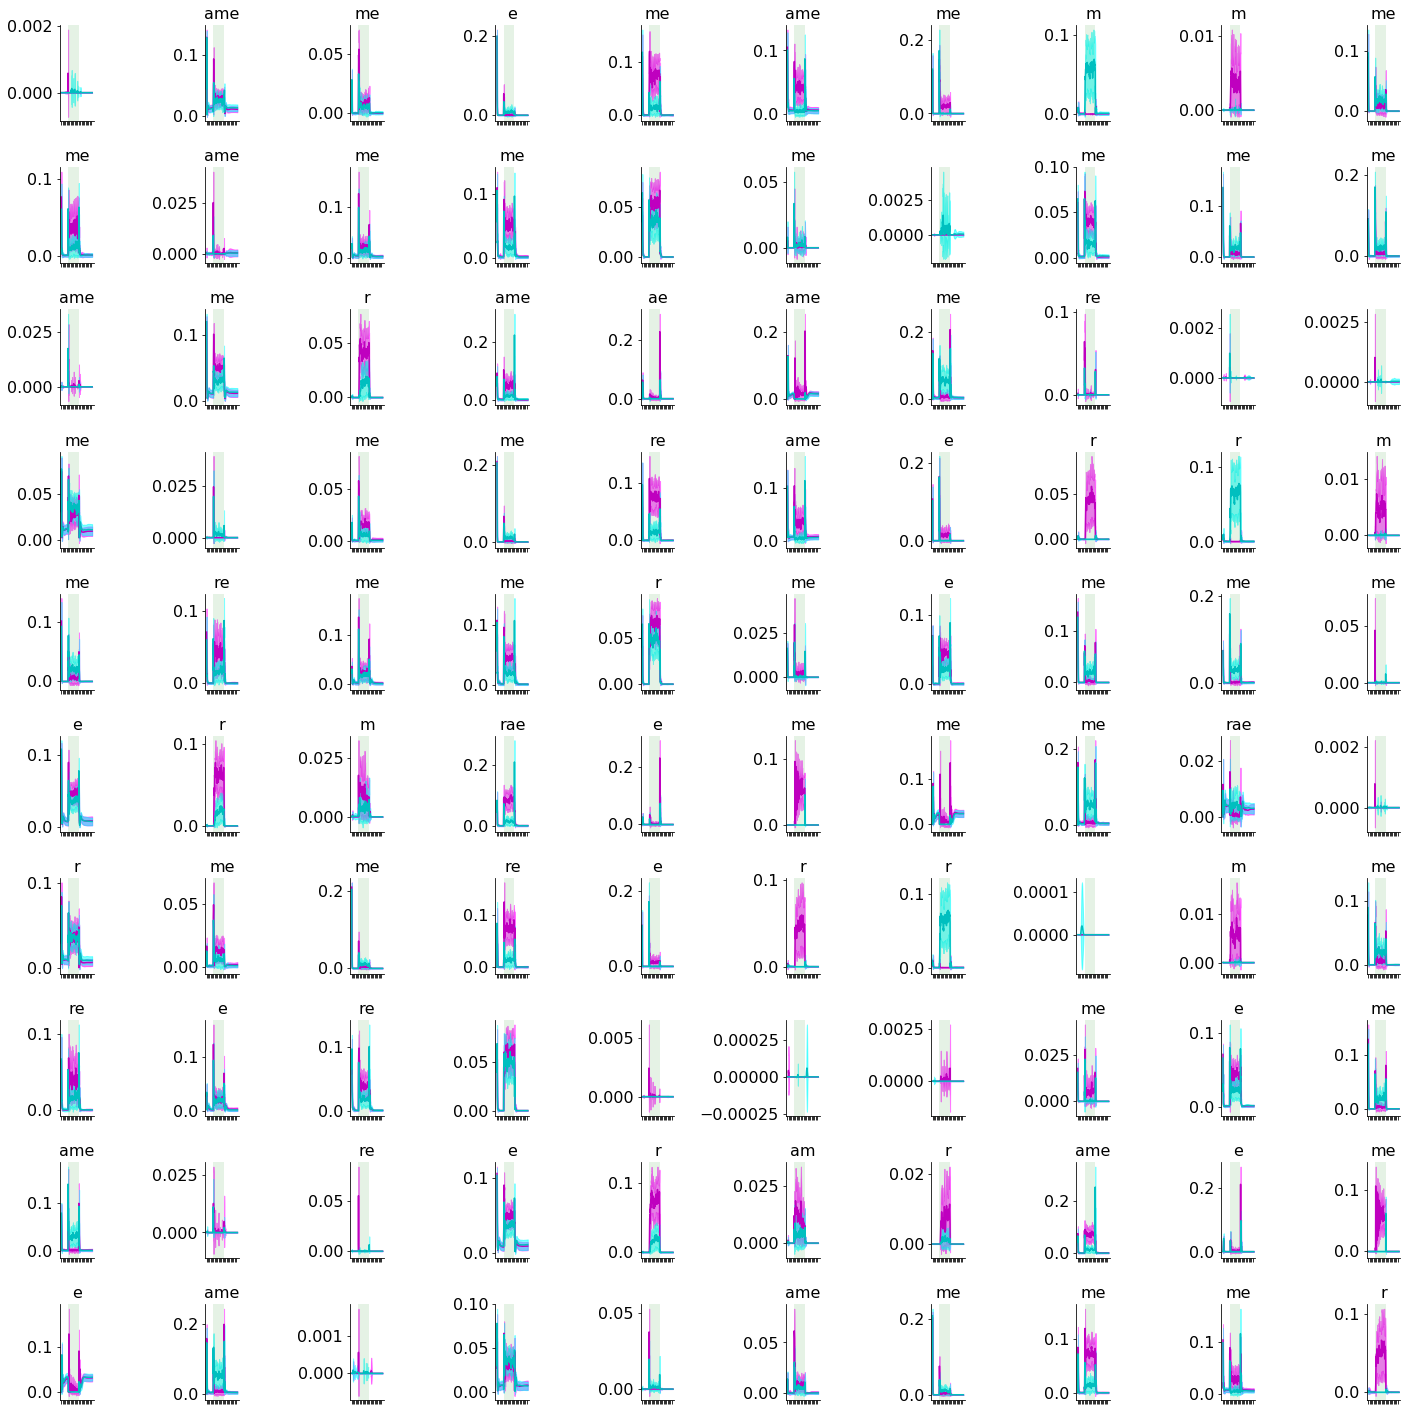

In [177]:
fig = plt.figure(figsize=(20, 20))

i = 100
plotted = 0
while True:
    if i not in flat_idx:
        plot_one(i, plotted + 1)        
        plotted += 1
        if plotted == 100:
            break
    i += 1
    
plt.tight_layout()
plt.show()
plt.close()

/home/ukita/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


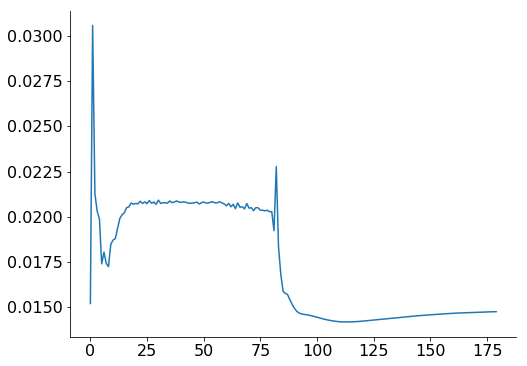

In [31]:
plt.plot(np.mean(resp_ind[0], axis=-1))
plt.show()

# connection

In [81]:
from keras.models import Model, model_from_json
from prednet import PredNet

WEIGHTS_DIR = './model/190724_11/'

weights_file = os.path.join(WEIGHTS_DIR, 'prednet_kitti_weights.hdf5')
json_file = os.path.join(WEIGHTS_DIR, 'prednet_kitti_model.json')

# Load trained model
f = open(json_file, 'r')
json_string = f.read()
f.close()
train_model = model_from_json(json_string, custom_objects = {'PredNet': PredNet})
train_model.load_weights(weights_file)

In [83]:
w = train_model.get_weights()

for i in range(len(w)):
    print(w[i].shape) # ['a', 'ahat', 'c', 'f', 'i', 'o'] order

# Ramp cells in A0

In [5]:
target = 'A0'
cell_dict = hickle.load(SAVE_DIR + 'cell_dict.hkl')
n_stims = 2

In [6]:
resp_deg0 = hickle.load(SAVE_DIR + 'MAE_P_deg0_' + target + '.hkl') # (10, 50, 12, 14, 192)
resp_deg180 = hickle.load(SAVE_DIR + 'MAE_P_deg180_' + target + '.hkl')

resp = np.zeros((n_stims, ) + resp_deg0.shape) # (4, 10, 50, 12, 14, 192)
resp[0] = resp_deg0
resp[1] = resp_deg180

# omit the pre frame
resp_ind = np.mean(resp, axis=1)[:, pre_frames:] # (4, 40, 12, 14, 192)

# reshape
# analyze all units
n_units = resp_ind.shape[2] * resp_ind.shape[3] * resp_ind.shape[4]
nt = resp_ind.shape[1]
resp_ind_new = resp_ind.reshape((n_stims, nt, n_units))

/home/ukita/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


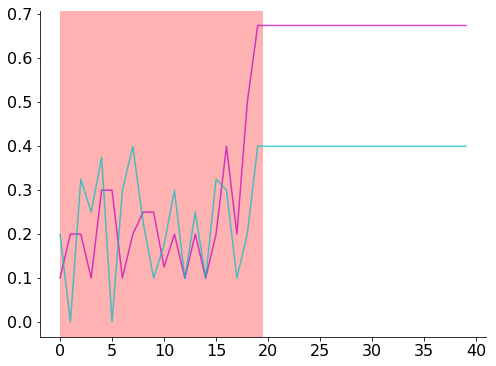

In [7]:
plt.errorbar(range(40), resp_ind[0, :, 0, 3, 0], c='m', alpha=0.7)
plt.errorbar(range(40), resp_ind[1, :, 0, 3, 0], c='c', alpha=0.7)
plt.axvspan(0, stim_frames - 0.5, facecolor='r', alpha=0.3)
plt.show()
plt.close()

In [9]:
stim = hickle.load('/export/public/ukita/prednet/stim/50frames192x224/MAE_P_deg0.hkl')
print(stim.shape)

stim_ = stim.reshape((10, 50, 192, 224, 3))

(500, 192, 224, 3)


/home/ukita/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


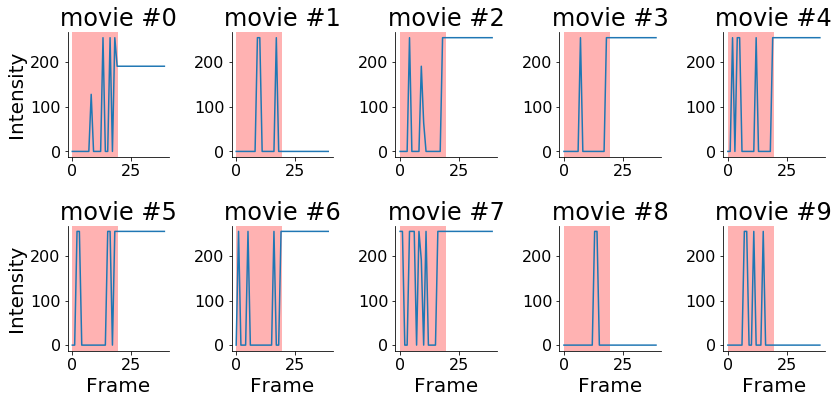

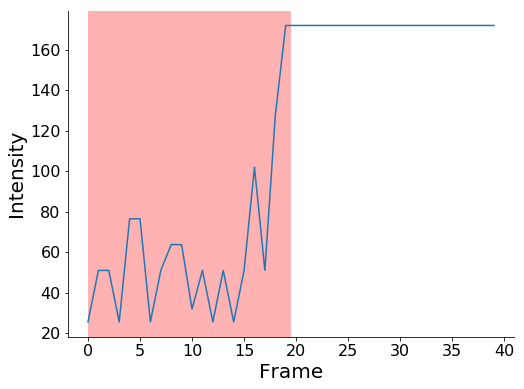

In [19]:
fig = plt.figure(figsize=(12, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    ax.plot(stim_[i, 10:50, 0, 3, 0])
    ax.axvspan(0, stim_frames - 0.5, facecolor='r', alpha=0.3)
    if i in range(5, 10):
        ax.set_xlabel('Frame')
    if i in [0, 5]:
        ax.set_ylabel('Intensity')
    ax.set_title('movie #' + str(i))
plt.tight_layout()
plt.show()
    
plt.plot(stim_[:, 10:50, 0, 3, 0].mean(axis=0))
plt.axvspan(0, stim_frames - 0.5, facecolor='r', alpha=0.3)
plt.xlabel('Frame')
plt.ylabel('Intensity')
plt.show()